In [1]:
!pip install category_encoders -q

In [2]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [3]:
#miscellaneous
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.m_estimate import MEstimateEncoder

#models
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#metrics and evaluation
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from catboost import cv, Pool

## Подготовка данных

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные загружены без ошибок

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сохраним размеры исходного датасета перед предобработкой

In [7]:
original_shape = df.shape

### Преобразование типов

Преобразуем даты в `datetime`

In [8]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%Y-%m-%d %H:%M:%S')

<a id='dupes_check'></a>

### Проверка на дубликаты

Выполним проверку на явные дубликаты

In [9]:
df.duplicated().sum()

4

In [10]:
df = df.drop_duplicates()

Выполним проверку на неявные дубликаты в категориальных признаках

In [11]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [12]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [14]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [15]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [16]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Явные дубликаты удалены, неявных не обнаружено

### Удаление пропусков

In [17]:
df.isna().mean().sort_values(ascending = False)

Repaired             0.200793
VehicleType          0.105795
FuelType             0.092828
Gearbox              0.055968
Model                0.055607
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропуски имеются только в категориальных меременных. Почти все из них можно попытаться восстановить на основании модели автомобиля. Пропуски в самих моделях достаточно малочисленны (5.6%), их можно удалить. В столбце `Repaired` заполним пропуски заглушкой `unknown`

In [18]:
df = df.dropna(subset = ['Model'])

In [19]:
def fill_by_key(column, key):
    for model, value in key.items():
        if type(value) == np.ndarray:
            df.loc[:, column][(df['Model'] == model) & (df[column].isna())] = value[0]
        else:
            df.loc[:, column][(df['Model'] == model) & (df[column].isna())] = value

In [ ]:
colums_to_fill = ['VehicleType', 'FuelType', 'Gearbox']

for column in colums_to_fill:
    key = df.groupby('Model')[column].agg(pd.Series.mode)
    fill_by_key(column, key)

In [21]:
df['Repaired'] = df['Repaired'].fillna(value = 'unknown')

In [22]:
df.isna().mean().sort_values(ascending = False)

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

### Очистка от выбросов

#### Цена

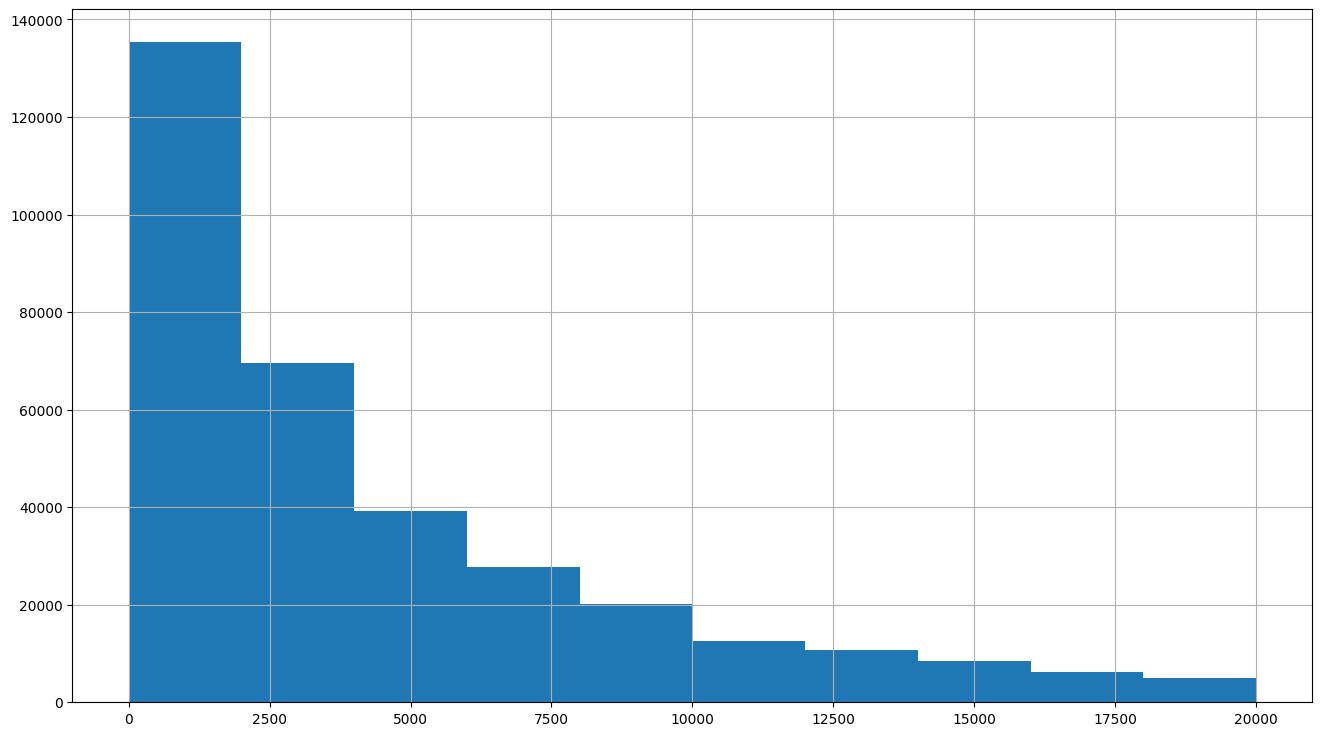

In [23]:
df['Price'].hist(figsize = (16, 9));

In [24]:
df['Price'].describe()

count    334660.000000
mean       4504.372249
std        4531.457109
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Имеются записи с неправдоподобно низкими ценами. Удалим их

In [25]:
df = df[df['Price'] > 100]

#### Год регистрации

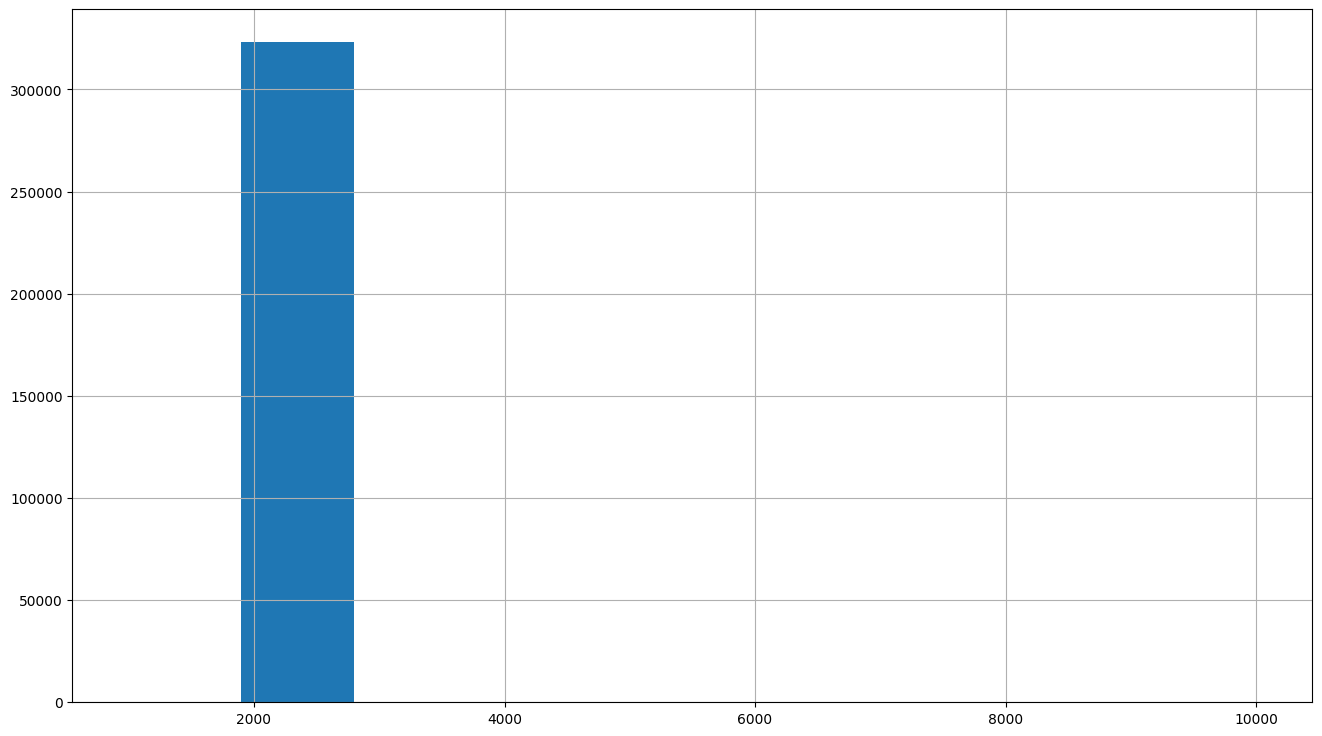

In [26]:
df['RegistrationYear'].hist(figsize = (16, 9));

In [27]:
df['RegistrationYear'].describe()

count    323131.000000
mean       2003.803136
std          55.796292
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Имеются как неправдоподобно большие, так и малые значения. Удалим значения, в которых год больше, чем год создания записи, а также записи с годом регистрации меньшим, чем 1990

In [28]:
(df['DateCrawled'].dt.year < df['DateCreated'].dt.year).sum()

0

In [29]:
df = df[(df['RegistrationYear'] <= df['DateCreated'].dt.year)]
df = df[df['RegistrationYear'] >= 1990]

#### Мощность

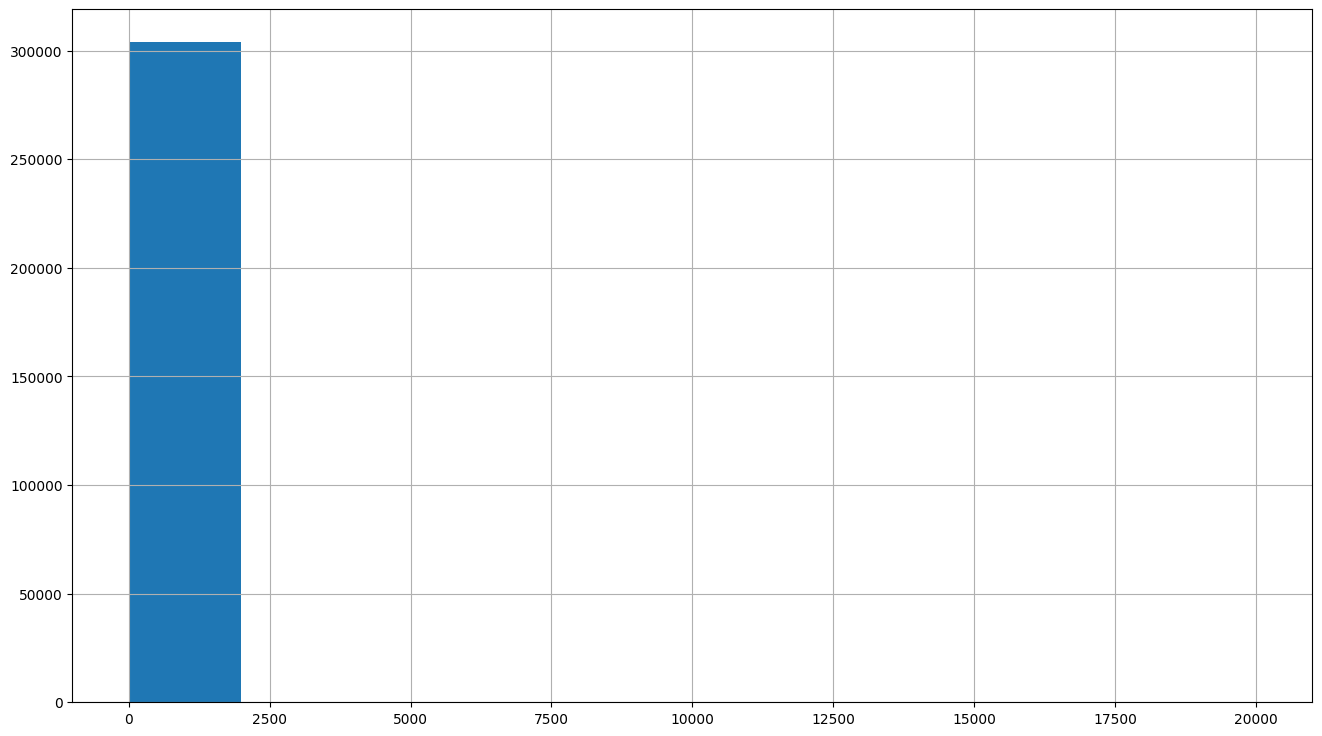

In [30]:
df['Power'].hist(figsize = (16, 9));

In [31]:
df['Power'].describe()

count    303906.000000
mean        113.959744
std         178.735462
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Мощность двигателя можно также попробовать восстановить по модели автомобиля

In [ ]:
low_threshold = 20
high_threshold = 1000

key = df.groupby('Model')['Power'].median()

for model, value in key.items():
    df.loc[:, 'Power'][(df['Model'] == model) & ( (df['Power'] < low_threshold) | (df['Power'] > high_threshold)  )] = value

In [33]:
df['Power'].describe()

count    303906.000000
mean        120.054632
std          52.996733
min           0.000000
25%          77.000000
50%         111.000000
75%         147.000000
max        1000.000000
Name: Power, dtype: float64

In [34]:
df[df['Power'] == 0]['Model'].unique()

array(['601'], dtype=object)

Мощность двигателя Trabant 601 - 26 л.с ([avto.ru](https://avto-russia.ru/autos/trabant/trabant_601.html#:~:text=Trabant%20601%20оснащался%202-цилиндровым,км%2Fчас%20за%2022.5%20с.))

In [35]:
df.loc[:, 'Power'][(df['Model'] == '601')] = 26

In [36]:
df['Power'].describe()

count    303906.000000
mean        120.057919
std          52.990073
min          20.000000
25%          77.000000
50%         111.000000
75%         147.000000
max        1000.000000
Name: Power, dtype: float64

#### Пробег

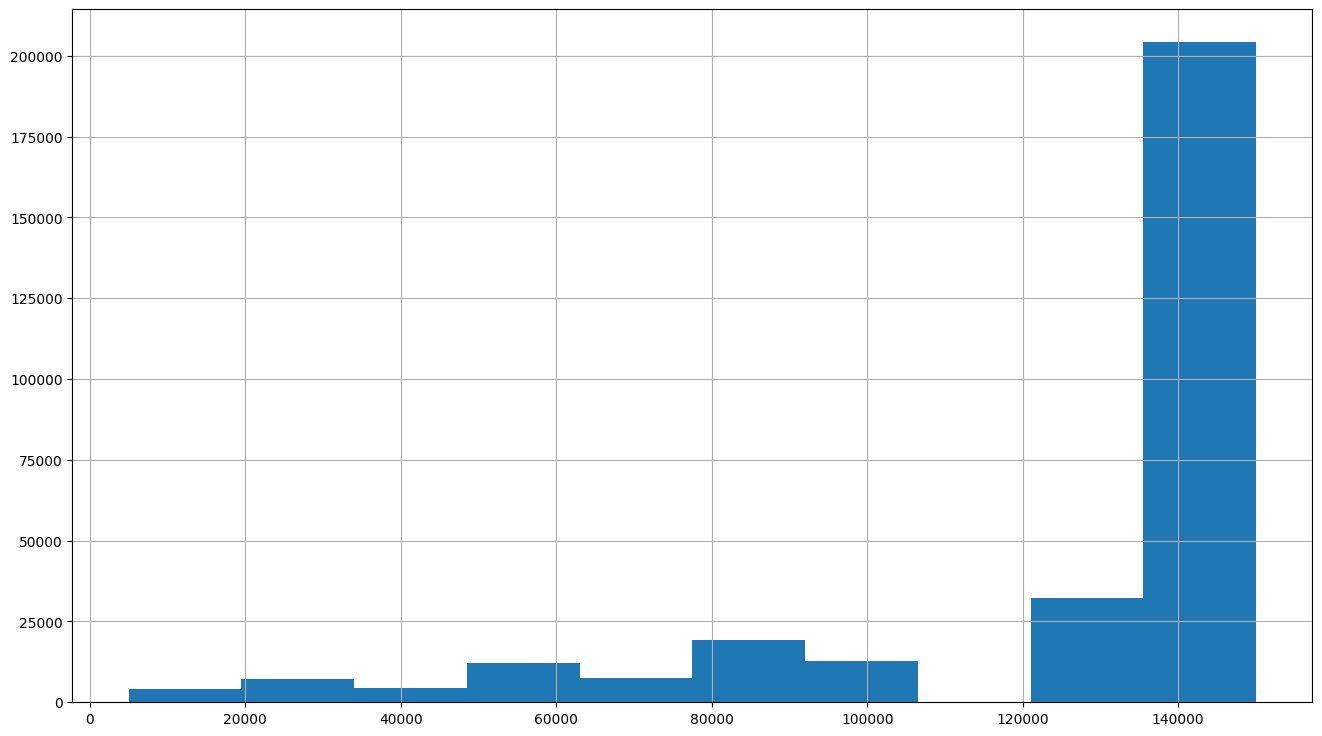

In [37]:
df['Kilometer'].hist(figsize = (16, 9));

In [38]:
df['Kilometer'].describe()

count    303906.000000
mean     128936.710693
std       36399.985983
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [39]:
df['Kilometer'].value_counts()

150000    204155
125000     32357
100000     12742
90000      10337
80000       8940
70000       7659
60000       6726
50000       5554
40000       4394
30000       3843
20000       3221
5000        3121
10000        857
Name: Kilometer, dtype: int64

Пробег в источнике указан со значительными округлениями. По одним только значениям пробега не представляется возможным проверить данные на выбросы. Расчитаем среднегодовой пробег

In [40]:
(df['Kilometer'] / (2017 - df['RegistrationYear'])).describe()

count    303906.000000
mean      13237.421498
std       20612.658694
min         185.185185
25%        7500.000000
50%        9375.000000
75%       12500.000000
max      150000.000000
dtype: float64

В 2022 году среднегодовой пробег автомобиля в РФ составлял 15 - 26 тыс. км / год ([interfax](https://www.interfax-russia.ru/far-east/news/srednegodovoy-probeg-avtomobiley-v-rossii-za-3-goda-vyros-na-2-7-tys-km-eksperty#:~:text=ИНТЕРФАКС%20-%20ДАЛЬНИЙ%20ВОСТОК%20-%20Средний%20пробег,служба%20специализированного%20автопортала%20"Дром".)). Выберем порог для удаления с некоторым запасом - 30 тыс. км / год

In [41]:
df = df[((df['Kilometer'] / (2017 - df['RegistrationYear'])) <= 30000)]

### Итог

In [42]:
df.shape[0] / original_shape[0]

0.8361538396417294

In [43]:
df.shape[0]

296307

Удалено довольно большое количество данных - около 12%. Однако, оставшийся датасет достаточно большой, чтобы продолжать с ним работать

## Обучение моделей
### Подготовка данных

Удвлим неинформативные признаки - даты создания и скачивания анкет, месяц регистрации, количество фото и почтовые индексы владельцев

In [44]:
columns_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
df = df.drop(columns_to_drop, axis = 1)

Выделим целевой признак

In [45]:
target = 'Price'
features = df.columns.drop(target)
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Конвертируем категориальные признаки в тип данных `category` для LGBM

In [46]:
for c in cat_features:
    df[c] = df[c].astype('category')

Разделим датасет на обучающую и тестовые выборки

In [47]:
train, test = train_test_split(df, test_size = 0.1, random_state = 42)

Проверим распределения количетсвенных переменных

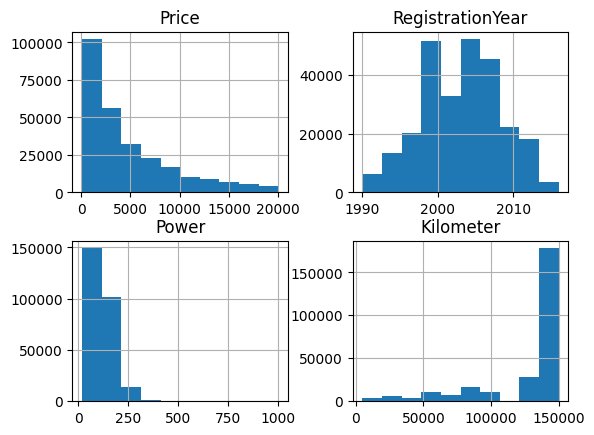

In [48]:
train.hist();

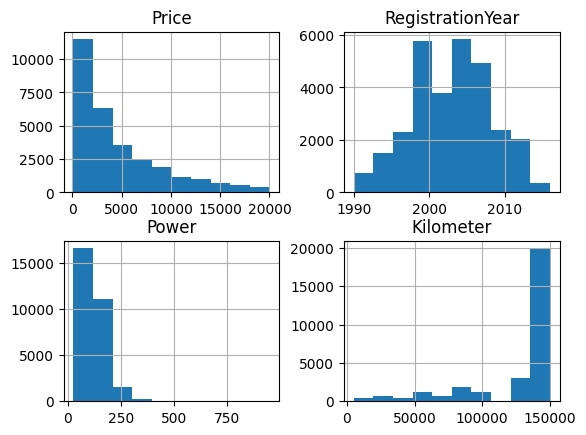

In [49]:
test.hist();

Формы распределений сходны. Проверим распределения категориальных переменных

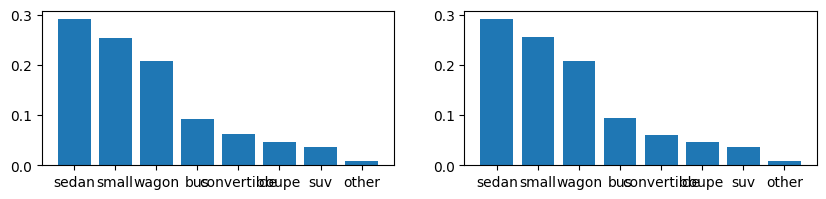

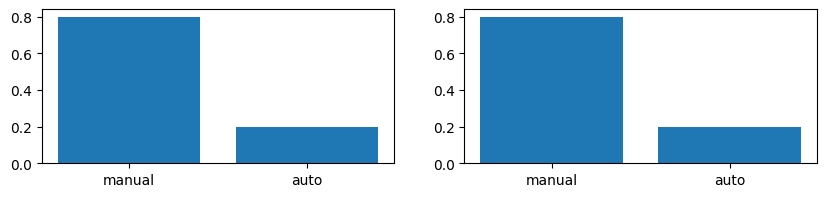

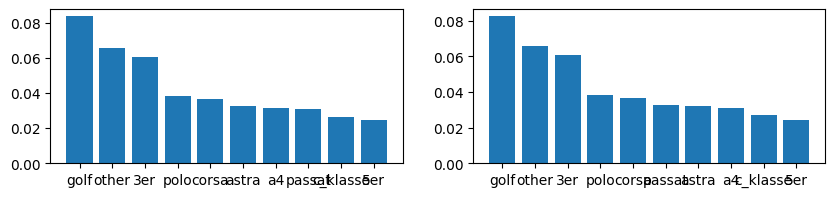

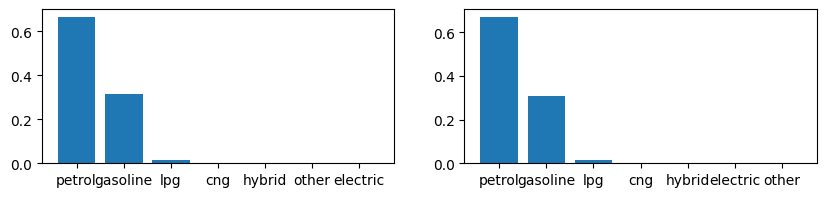

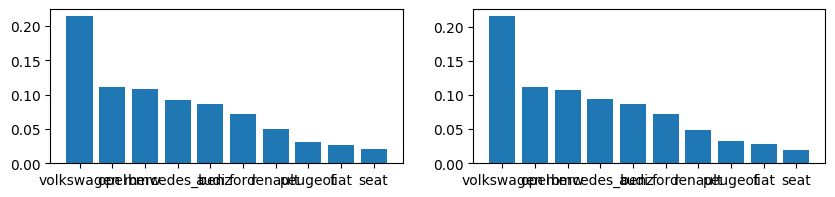

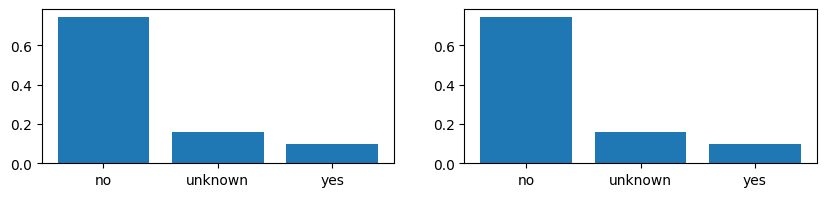

In [50]:
for feature in cat_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))
    ax1.bar(train[feature].value_counts(normalize = True).head(10).index, train[feature].value_counts(normalize = True).head(10).values)
    ax2.bar(test[feature].value_counts(normalize = True).head(10).index, test[feature].value_counts(normalize = True).head(10).values)
    plt.show()

Распределения сходны

### LGBM

In [51]:
lgbr_params = {
    'max_depth' : [1, 10, 15],
    'n_estimators' : [10, 20]
}

In [52]:
lgbr = GridSearchCV(LGBMRegressor(random_state = 42), lgbr_params, scoring = 'neg_root_mean_squared_error', cv = 3)

In [ ]:
%%time
lgbr.fit(train[features], train[target])

In [54]:
lgbr_scores = pd.DataFrame(lgbr.cv_results_).sort_values(by = 'rank_test_score')
lgbr_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.568313,0.002709,0.126724,0.001737,10,20,"{'max_depth': 10, 'n_estimators': 20}",-1848.356235,-1853.328164,-1836.727738,-1846.137379,6.956341,1
5,0.566945,0.006567,0.128626,0.002521,15,20,"{'max_depth': 15, 'n_estimators': 20}",-1848.356235,-1853.328164,-1836.727738,-1846.137379,6.956341,1
2,0.399813,0.008076,0.062104,0.003833,10,10,"{'max_depth': 10, 'n_estimators': 10}",-2451.399400,-2457.061456,-2427.749249,-2445.403368,12.695555,3
4,0.401345,0.003715,0.060703,0.003064,15,10,"{'max_depth': 15, 'n_estimators': 10}",-2451.399400,-2457.061456,-2427.749249,-2445.403368,12.695555,3
1,0.335610,0.004627,0.036013,0.000462,1,20,"{'max_depth': 1, 'n_estimators': 20}",-2981.108583,-2991.358573,-2955.849317,-2976.105491,14.922020,5


Измерим время обучения на всех тестовых данных

In [55]:
lgbr = lgbr.best_estimator_

In [ ]:
%%time
lgbr.fit(train[features], train[target])

Измерим время предсказания на тестовой выборке

In [57]:
%%time
lgbr.predict(test[features])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 64.1 ms, sys: 0 ns, total: 64.1 ms
Wall time: 66.7 ms


array([6227.09706914, 1603.83082476, 2252.71976791, ..., 1350.11552283,
       3199.91508433, 5188.17636139])

Расчитаем итоговое значение RMSE и соберём результаты в список

In [58]:
lgbr_rmse = mean_squared_error(test[target], lgbr.predict(test[features]), squared = False)
lgbr_rmse

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


1821.8574208481984

In [59]:
lgbr_results = [lgbr_rmse, 63, 0.2]

### CatBoost

In [60]:
cb_params = {
             'loss_function': 'RMSE',
             'learning_rate': 0.2,
             'iterations' : 1000,
             'random_seed': 42,
             'verbose':100}

train_data = Pool(data=train[features],
                  label=train[target],
                  cat_features = cat_features
                 )

test_data = Pool(data=test[features],
                  label=test[target],
                  cat_features = cat_features
                 )


In [61]:
cv_data = cv(
    params = cb_params,
    pool = train_data,
    fold_count=3,
    partition_random_seed=42,
    verbose=200,
    early_stopping_rounds=50
)

Training on fold [0/3]
0:	learn: 5487.6605800	test: 5491.5638484	best: 5491.5638484 (0)	total: 616ms	remaining: 10m 15s
200:	learn: 1519.5091667	test: 1564.8241031	best: 1564.8241031 (200)	total: 41.3s	remaining: 2m 44s
400:	learn: 1462.4685447	test: 1530.3694888	best: 1530.3694888 (400)	total: 1m 22s	remaining: 2m 3s
600:	learn: 1431.7229021	test: 1515.2666922	best: 1515.2666922 (600)	total: 2m 3s	remaining: 1m 21s
800:	learn: 1405.6721579	test: 1505.8122770	best: 1505.8122770 (800)	total: 2m 44s	remaining: 40.8s
999:	learn: 1386.5048486	test: 1498.6348904	best: 1498.6162263 (998)	total: 3m 24s	remaining: 0us

bestTest = 1498.616226
bestIteration = 998

Training on fold [1/3]
0:	learn: 5495.1254357	test: 5476.3215939	best: 5476.3215939 (0)	total: 307ms	remaining: 5m 6s
200:	learn: 1519.5693878	test: 1548.8462930	best: 1548.8462930 (200)	total: 41.4s	remaining: 2m 44s
400:	learn: 1461.9384080	test: 1512.6226834	best: 1512.5964792 (399)	total: 1m 22s	remaining: 2m 3s
600:	learn: 1429.53

Надём время обучения на всей обучающей выборке

In [62]:
%%time
cat_reg = CatBoostRegressor(**cb_params)
cat_reg.fit(train_data)

0:	learn: 3936.3794893	total: 327ms	remaining: 5m 26s
100:	learn: 1580.3321266	total: 25.6s	remaining: 3m 47s
200:	learn: 1519.7231047	total: 51.1s	remaining: 3m 23s
300:	learn: 1487.2187684	total: 1m 15s	remaining: 2m 56s
400:	learn: 1467.7335263	total: 1m 41s	remaining: 2m 31s
500:	learn: 1450.7095518	total: 2m 6s	remaining: 2m 5s
600:	learn: 1436.9645838	total: 2m 30s	remaining: 1m 40s
700:	learn: 1425.1776564	total: 2m 56s	remaining: 1m 15s
800:	learn: 1415.3969921	total: 3m 20s	remaining: 49.9s
900:	learn: 1406.8339925	total: 3m 45s	remaining: 24.8s
999:	learn: 1399.3539715	total: 4m 10s	remaining: 0us
CPU times: user 7min 15s, sys: 3.28 s, total: 7min 18s
Wall time: 4min 13s


Найдём время предсказания на тестовой выборке

In [63]:
%%time
cat_reg.predict(test[features])

CPU times: user 552 ms, sys: 101 ms, total: 652 ms
Wall time: 531 ms


array([7592.64993316,  517.01578577, 1884.57179342, ...,  290.30188183,
       2608.34048582, 4554.28650679])

Найдём RMSE

In [64]:
cat_rmse = mean_squared_error(test[target], cat_reg.predict(test[features]), squared = False)
cat_rmse

1465.2432171354997

In [65]:
cat_results = [cat_rmse, 220, 0.225]

### Линейная регрессия

Для линейной регрессии придётся произвести преобразование категориальных признаков

In [66]:
features

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [69]:
cat_features_oh = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
cat_features_m = ['Model', 'Brand']

In [70]:
encoder = OneHotEncoder(sparse = False, drop = 'first', )

train_encoded = pd.DataFrame(encoder.fit_transform(train[cat_features_oh]), columns = encoder.get_feature_names_out())
train_encoded = train_encoded.set_index(train.index)
train_encoded = pd.concat([train.drop(cat_features_oh, axis = 1), train_encoded], axis = 1)

test_encoded = pd.DataFrame(encoder.transform(test[cat_features_oh]), columns = encoder.get_feature_names_out())
test_encoded = test_encoded.set_index(test.index)
test_encoded = pd.concat([test.drop(cat_features_oh, axis = 1), test_encoded], axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [71]:
train_encoded.columns

Index(['Price', 'RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       'VehicleType_wagon', 'Gearbox_manual', 'FuelType_electric',
       'FuelType_gasoline', 'FuelType_hybrid', 'FuelType_lpg',
       'FuelType_other', 'FuelType_petrol', 'Repaired_unknown',
       'Repaired_yes'],
      dtype='object')

In [72]:
m_encoder = MEstimateEncoder(cols = cat_features_m)
train_encoded = m_encoder.fit_transform(train_encoded, train_encoded[target])
test_encoded = m_encoder.transform(test_encoded)

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Отлично, твой вариант помогает победить "проклятье размерности".
</div>

In [73]:
train_encoded.head()

,Price,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_unknown,Repaired_yes
238267,2500,2005,147.0,3802.606729,150000,2805.985459,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
250727,2000,1999,170.0,6669.808791,150000,6603.334884,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
262818,20000,2011,265.0,5654.853776,50000,6245.031019,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
250998,4490,2003,88.0,7102.065785,150000,4789.197821,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70489,5000,1999,116.0,5317.508747,150000,4789.197821,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
test_encoded.head()

,Price,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_unknown,Repaired_yes
252972,5900,2005,204.0,5654.853776,150000,6245.031019,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
293817,850,1999,132.0,4447.617762,150000,3352.978331,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
92838,1499,2000,105.0,4515.122378,150000,4789.197821,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
317094,9900,2013,94.0,4196.224818,50000,4257.645954,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
317427,120,1993,90.0,2694.104424,100000,3389.201564,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Произведём масштабирование числовых признаков для линейной регрессии

In [75]:
encoded_features = train_encoded.columns.drop(target)
encoded_features_mumeric = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']

In [76]:
scaler = StandardScaler()
train_encoded[encoded_features_mumeric] = scaler.fit_transform(train_encoded[encoded_features_mumeric])
test_encoded[encoded_features_mumeric] = scaler.transform(test_encoded[encoded_features_mumeric])

In [77]:
train_encoded.head()

,Price,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_unknown,Repaired_yes
238267,2500,0.384577,0.499296,-0.387691,0.583603,-1.264629,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
250727,2000,-0.763982,0.933092,0.769857,0.583603,1.187932,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
262818,20000,1.533137,2.724858,0.360099,-2.144491,0.956518,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
250998,4490,0.001724,-0.613485,0.944368,0.583603,0.016252,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
70489,5000,-0.763982,-0.085386,0.223906,0.583603,0.016252,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [78]:
linear_reg = LinearRegression()

In [79]:
%%time
cross_val_score(
    linear_reg,
    train_encoded[encoded_features],
    train_encoded[target],
    scoring = 'neg_root_mean_squared_error',
    cv = 3)

CPU times: user 807 ms, sys: 530 ms, total: 1.34 s
Wall time: 928 ms


array([-2423.67844784, -2418.33348229, -2401.87859908])

In [80]:
%%time
linear_reg.fit(train_encoded[encoded_features], train_encoded[target])

CPU times: user 375 ms, sys: 211 ms, total: 586 ms
Wall time: 426 ms


LinearRegression()

In [81]:
%%time
linear_reg.predict(test_encoded[encoded_features])

CPU times: user 9.23 ms, sys: 12.8 ms, total: 22 ms
Wall time: 12.8 ms


array([ 7598.43848217,  1218.12211066,  2111.93697237, ...,
       -4382.1920679 ,  3499.54223741,  5391.3402216 ])

In [82]:
linear_reg_rmse = mean_squared_error(test_encoded[target], linear_reg.predict(test_encoded[encoded_features]), squared = False)
linear_reg_rmse

2396.632828207559

In [83]:
lin_results = [linear_reg_rmse, 16.9, 0.132]

Проведено обучение трёх моделей - LGBM, CatBoost и линейной регрессии, расчитаны значения целевой метрики - RMSE, для дальнейшего анализа сохранено время обучения/предсказания

## Анализ моделей

In [84]:
scores = pd.DataFrame(
    [lgbr_results, cat_results, lin_results],
    index = ['LGBM', 'CatBoost', 'Linear regression'],
    columns = ['test_RMSE', 'fit_time', 'predict_time']
)

In [85]:
scores

,test_RMSE,fit_time,predict_time
LGBM,1821.857421,63.0,0.200
CatBoost,1465.243217,220.0,0.225
Linear regression,2396.632828,16.9,0.132


Наиболее точные предсказания у модели CatBoost, время предсказания сходно с LGBM, однако время обучения значительно дольше. Модель базовой линейной регрессии показывает худшие результаты (которые, тем не менее, укладываются в заданный порог в 2500), но при этом обучается и формирует предсказания быстрее всего.

## Вывод

Изучены данные о ценах на автомобили с пробегом.

1. Проведена предобработка данных
    - проведено преобразование данных с датами/временем к типу `datetime`
    - удалены пропуски в признаке `model`
    - пропуски в признаке `repaired` заменены заглушками
    - пропуски в категориальных переменных заполнены модами по соответствующим моделям
2. Проведена обработка выбросов
    - удалены данные с неправдоподобными ценами и годами регистрации
    - аномальные данные о мощности заполнены медианами по соответствующим моделям
    - для оценки выбросов в данных о пробеге был расчитан среднегодовой пробег, удалены данные с аномально высоким среднегодовым пробегом
    - итого удалено ~12% данных
3. Проведено сравнение моделей машинного обучения - LGBM, CatBoost и линейной регрессии.
    - наиболее высокую скорость обучения показывает линейная регрессия - обучение ~ в 3.3 раза быстрее LGBM и ~ в 11.5 раз быстрее CatBoost
    - наименьшее время предсказаний также показывает линейная регрессия, однако разница между ней и наиболее медленным CatBoost меньше 100 мс
    - все модели имеют тестовое значение RMSE ниже порогового (2500), наименьшее значение у CatBoost (1461)
4. Поскольку чёткие критерии о важности точности и скорости в задании отсутствуют, то наилучшим вариантом будет LGBM с приемлемой скоростью работы и точностью предсказаний. Однако, если клиенту важна точность предсказаний, то можно рекомендовать CatBoost - обучается он гораздо медленнее, но скорость предсказаний сопоставима с LGBM при гораздо более высокой точности